In [27]:
# importing the libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

# Importing the warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
import wordcloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kavitha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kavitha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kavitha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kavitha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [34]:
df = pd.read_csv('spam_detection.csv',delimiter='\t',encoding='latin-1')
df

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0.0
1,NaN,"lang classification grimes , joseph e . and ba...",0.0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0.0
3,risk,a colleague and i are researching the differin...,0.0
4,request book information,earlier this morning i was on the phone with a...,0.0
...,...,...,...
2886,love your profile - ysuolvpv,hello thanks for stopping by ! ! we have taken...,1.0
2887,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1.0
2888,anglicization of composers ' names,"judging from the return post , i must have sou...",0.0
2889,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0.0


In [35]:
df.shape

(2891, 3)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   subject  2834 non-null   object 
 1   message  2819 non-null   object 
 2   label    2819 non-null   float64
dtypes: float64(1), object(2)
memory usage: 67.9+ KB


Now we check the spam and non-spam emails in the dataset.

In [37]:
#Checking the shape of the dataset
print("Shape of the dataset:", df.shape)

Shape of the dataset: (2891, 3)


In [38]:
#Checking for the null values
df.isnull().values.any()

True

In [39]:
df.isnull().sum()

subject    57
message    72
label      72
dtype: int64

Observations:

57 rows are missing in the subject columns that means 72 emails are without subject heading.
Here, not dropping Nan rows for subject column as it of no use in building model.

In [40]:
#Checking total number of mails
print("Count of label:\n",df['label'].value_counts())

Count of label:
 0.0    2350
1.0     469
Name: label, dtype: int64


Here, we see that 1 stand for Spam mail and 0 stand for not a spam mail.

In [41]:
#Checking the Ratio of labels
print("Not a Spam Email Ratio i.e. 0 label:",round(len(df[df['label']==0])/len(df['label']),2)*100,"%")
print("Spam Email Ratio that is 1 label:",round(len(df[df['label']==1])/len(df['label']),2)*100,"%")

Not a Spam Email Ratio i.e. 0 label: 81.0 %
Spam Email Ratio that is 1 label: 16.0 %


Proceeding with Checking Ratio or percentage of Labels i.e. Spam and Non-Spam emails and observe that 16% mails are Spam emails and rest 81% are Not a Spam emails.

Now we create a new feature named length to check the length of each message and convert every alphabet to lower case in the message.

In [42]:
#Creating the new column for length of message column
df['length'] = df.message.str.len()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0.0,2856.0
1,NaN,"lang classification grimes , joseph e . and ba...",0.0,1800.0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0.0,1435.0
3,risk,a colleague and i are researching the differin...,0.0,324.0
4,request book information,earlier this morning i was on the phone with a...,0.0,1046.0


In [43]:
#Converting all messages to lower case
df['message'] = df['message'].str.lower()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0.0,2856.0
1,NaN,"lang classification grimes , joseph e . and ba...",0.0,1800.0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0.0,1435.0
3,risk,a colleague and i are researching the differin...,0.0,324.0
4,request book information,earlier this morning i was on the phone with a...,0.0,1046.0


# Regular Expressions

In [49]:
# Replace email addresses with 'email'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace currency symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['message'] = df['message'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['message'] = df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
   
# Replace numeric characters with 'numbr'
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [45]:
# Remove punctuation
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['message'] = df['message'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['message'] = df['message'].str.replace(r'^\s+|\s+?$', '')

In [46]:
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0.0,2856.0
1,NaN,lang classification grimes joseph e and barbar...,0.0,1800.0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas sa...,0.0,1435.0
3,risk,a colleague and i are researching the differin...,0.0,324.0
4,request book information,earlier this morning i was on the phone with a...,0.0,1046.0


In [48]:
df.isnull().sum()

subject    57
message    72
label      72
length     72
dtype: int64

In [50]:
df=df.dropna()

In [51]:
df.isnull().sum()

subject    0
message    0
label      0
length     0
dtype: int64

Besides all these steps, now we do some common tasks that can be done on every NLP project.

We have to clean the data using regex, matching patterns in the e-mail messages, and replace them with more organized counterparts. Cleaner data leads to a more efficient model and higher accuracy. Following steps are involved in pre-processing the messages :

1.) Replace email address

2.) Replace URLs

3.) Replace currency symbols

4.) Replace 10 digits phone numbers (formats include parenthesis, spaces, no spaces, dashes)

5.) Replace numeric characters

6.) Removing punctuation

7.) Replace whitespace between terms with a single space

8.) Remove leading and trailing whitespace

It’s time to do tokenization. Now, what is Tokenization?

Tokenization is a critical step in NLP. We cannot simply jump into the model-building part without cleaning the text first. It is done by removing stop words.

9.) Removing Stop Words: There is a corpus of stop words, that are high-frequency words such as “the”, “to” and “also”, and that we sometimes want to liter out of a document before further processing. Stop-words usually have little lexical content, do not alter the general meaning of a sentence and their presence in a text fails to distinguish it from other texts.

After removing stop words, we have to create another feature named clean_length to compare the cleaned message length with unprocessed message length.

In [52]:
import string
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['message'] = df['message'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))

Now checking some information about lengths :

In [53]:
# New column (clean_length) after puncuations,stopwords removal
df['clean_length'] = df.message.str.len()
df.head()

,subject,message,label,length,clean_length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0.0,2856.0,2179
2,query : letter frequencies for text identifica...,posting inquiry sergei atamas satamas umabnet ...,0.0,1435.0,1064
3,risk,colleague researching differing degrees risk p...,0.0,324.0,210
4,request book information,earlier morning phone friend mine living south...,0.0,1046.0,629
5,call for abstracts : optimality in syntactic t...,content length numbr call papers best good eno...,0.0,4492.0,3370


In [54]:
#Total length removal
print("Original Length:",df.length.sum())
print("Cleaned Length:",df.clean_length.sum())
print("Total Words Removed:",(df.length.sum()) - (df.clean_length.sum()))

Original Length: 8663127.0
Cleaned Length: 6276224
Total Words Removed: 2386903.0


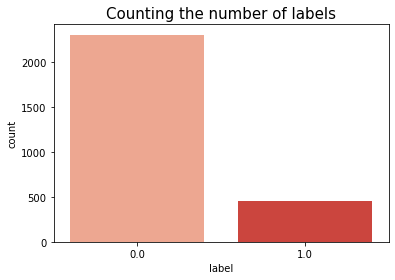

0.0    2306
1.0     456
Name: label, dtype: int64


In [55]:

#Graphical Visualisation for counting number of labels.
plt.figure(figsize=(6,4))
sns.countplot(df['label'],palette= 'Reds')
plt.title("Counting the number of labels",fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

print(df.label.value_counts())

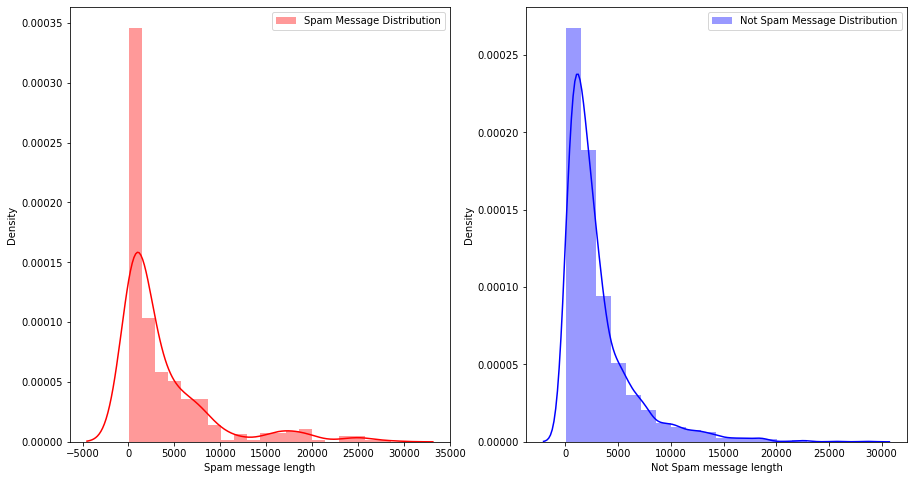

In [56]:
#Message distribution before cleaning
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='b')
ax[1].set_xlabel('Not Spam message length')
ax[1].legend()

plt.show()

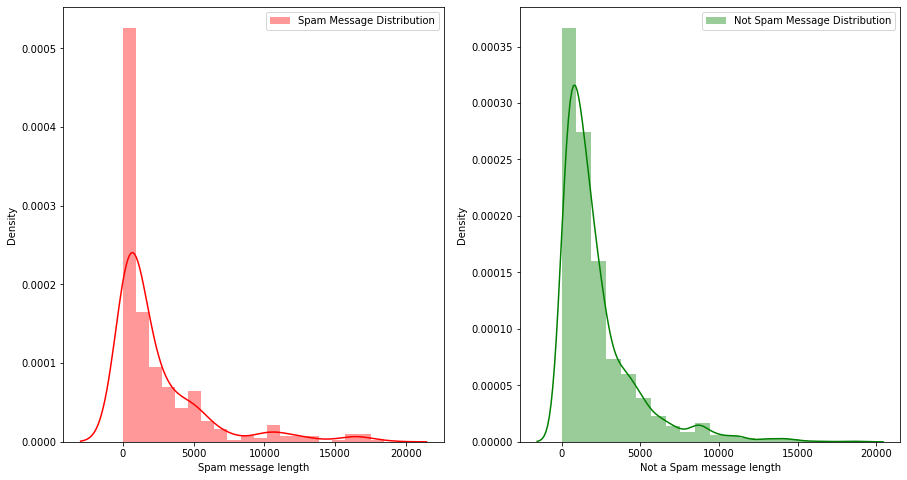

In [57]:
#Message distribution after cleaning
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['clean_length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['clean_length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='g')
ax[1].set_xlabel('Not a Spam message length')
ax[1].legend()

plt.show()

Let’s visualize some popular terms in spam messages using a word cloud. The word cloud library in NLTK will be used for this purpose.

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance.

Getting a sense of loud words in Spam email messages :

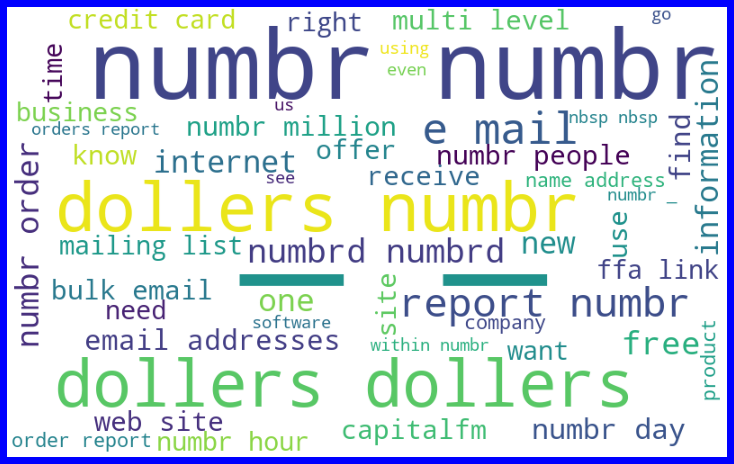

In [58]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud


spams = df['message'][df['label']==1]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

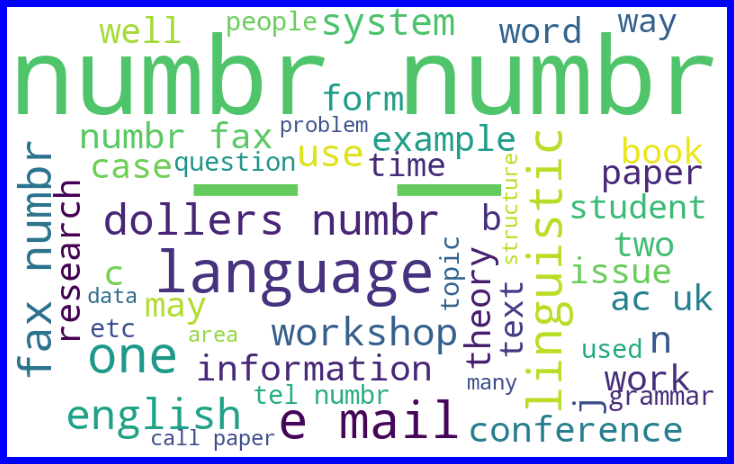

In [59]:
#Getting sense of loud words in not-spam 
from wordcloud import WordCloud

not_spams = df['message'][df['label']==0]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(not_spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

We have our processed data ready for the modeling.

# Converting the text into vectors using TF-IDF

In [60]:
# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label


tf_vec = TfidfVectorizer()

#naive = MultinomialNB()

SVM = SVC(C=1.0, kernel='linear', degree=3 , gamma='auto')

features = tf_vec.fit_transform(df['message'])

X = features
y = df['label']

In [66]:
print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.9884225759768451


In [61]:
# Train and predict
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)         #test_size=0.20 random_state=42 test_size=0.15

#naive.fit(X_train,Y_train)
#y_pred= naive.predict(x_test)

SVM.fit(X_train,Y_train)
y_pred = SVM.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.9884225759768451


In [62]:

y_pred

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0.

In [63]:
# Checking Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       573
         1.0       1.00      0.93      0.96       118

    accuracy                           0.99       691
   macro avg       0.99      0.97      0.98       691
weighted avg       0.99      0.99      0.99       691



6.) Checking Model prediction:
    
To check model performance, we will now plot different performance metrics.

a.) Plotted Confusion Matrix:

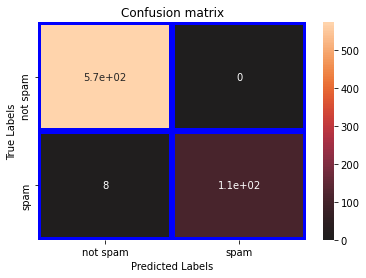

In [64]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='b',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['not spam','spam'])
ax.yaxis.set_ticklabels(['not spam','spam'])
plt.show()

Observation: In naive_bayes the accuracy score was in between 83 to 88 % & in SVM the accuracy score is around 98%.

From both models we see SVM performs better than naive_bayes .

4.) Run and Evaluate selected models:

1.) We use the Tf-idf vectorizer to convert the alphabetical messages into numeric form.


2.) After vectorizing the messages, we fit and feed them as input for the model and feature label as output.


3.) Here, I’m using two algorithms Naïve Bayes and SVM to compare the accuracy percentage.


4.) In Naïve Bayes, the accuracy percentage raised from 83% to max 88% even after minimizing the test size in the train test split.


5.) But in SVM the accuracy percentage went up to 98% showing better results than Naïve Bayes.


SVM with parameters : ( C=1.0 , kernel = ‘linear’, degree=3 , gamma=’auto’ )


6.) After applying all the suitable algorithms on the dataset we see that SVM is performing better than Naïve Bayes therefore it fits best for our objective.


Hence, all the further process is done in SVM.

5.) Final Results :

Results observed by evaluating the SVM model :


Final score = >  0.9884225759768451

# Saving SVM as our final model.

In [65]:
#We see SVM to perform the best.
#save the best model.
import pickle
filename='Email_spam_detect.pkl'
M=open(filename,'wb')
pickle.dump(SVM,M)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
M.close()

Observation :
    
Confusion Matrix shows high accuracy in predicting true values:
    

Out of total spam emails, very few are identified as non-spam emails rest all are correctly identified.


We see from above, that the SVM model gives us the best accuracy when performs with all the metrics.

# Concluding Remarks

1.Done all the pre-processing steps to make data ready for model building.


2.Removed stop words and create another feature ‘clean_length’ for comparing cleaned and unprocessed message length.


3. Understood relationship and gain insights by using Data Visualization:

    
a. Plotted count plot for checking spam and non-spam email counts.
b. Message Distribution before and after cleaning.
c. Lastly, visualize some popular terms in spam messages using the word cloud.

4.Used Tf-idf vectorizer to convert text into vector.


5.Found the best model as SVM which provides max accuracy of 98.75%.


6. Found high precision and recall score of 0.99.


7. Confusion matrix shows high classification accuracy with only 8 out of 481 are incorrect.


8.Overall model fit is good.